In [1]:
from main import *

/tmp/ipykernel_19466/2929591787.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for x, y in poses2d.astype(np.int):
/tmp/ipykernel_19466/2929591787.py:32: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.

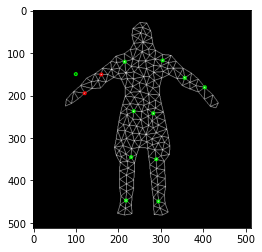

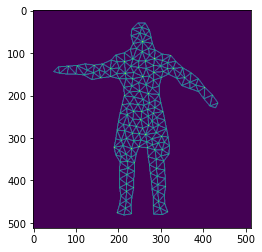

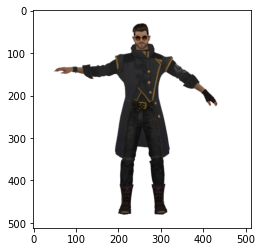

In [2]:
image_path = "./data/image_alok.png"
mask_path = "./data/mask_alok.png"
poses2d_path = "./data/poses2d.npy"

#
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w = image.shape[:2]
mask = cv2.imread(mask_path, 0)
poses2d = np.load(poses2d_path)

#
tri_mc = TriangleMeshCreator(interval=20, angle_constraint=20, area_constraint=200, dilated_pixel=5)
mesh = tri_mc.create(image, mask)

#
vertices = 0.5 * (mesh.vertices + 1) * np.array([w, h]).reshape((1, 2)).astype(np.float32)
distance = cdist(poses2d, vertices)
constraint_v_ids = np.argmin(distance, axis=1)
poses2d = vertices[constraint_v_ids]
constraint_v_coords = augment_handle_points(poses2d, size=(w, h))

constraint_v_ids = np.array([e for i, e in enumerate(constraint_v_ids) if i != 3])
constraint_v_coords = np.array([e for i, e in enumerate(constraint_v_coords) if i != 3])

if VISUALIZE:
    vis_image = mesh.get_image()
    vis_image = cv2.cvtColor(vis_image, cv2.COLOR_GRAY2BGR)
    for x, y in poses2d.astype(np.int):
        cv2.circle(vis_image, (x, y), radius=3, color=(255, 0, 0), thickness=2)

    for x, y in constraint_v_coords.astype(np.int):
        cv2.circle(vis_image, (x, y), radius=3, color=(0, 255, 0), thickness=2)

    im_utils.imshow(vis_image)

#
constraint_v_coords = Mesh.normalize_vertices(constraint_v_coords, size=(w, h))

# build vertices texture
vts = 0.5 * (mesh.vertices + 1)
vts[:, 1] = 1. - vts[:, 1]

# deform
arap_deform = ARAPDeformation()
arap_deform.load_from_mesh(mesh)
arap_deform.setup()

deformed_mesh = arap_deform.deform(constraint_v_ids, constraint_v_coords, w=1000.)
save_obj_format(file_path=DEFORM_MESH_PATH, vertices=deformed_mesh.vertices, faces=deformed_mesh.faces,
                texture_vertices=vts)

if VISUALIZE:
    vis_image = deformed_mesh.get_image(size=(w, h))
    im_utils.imshow(vis_image)

#
pt_renderer = render_utils.PytorchRenderer(use_gpu=False)
deformed_image = pt_renderer.render_w_texture(DEFORM_MESH_PATH, image_path)
deformed_image = deformed_image[::-1, :, :]
deformed_image = cv2.cvtColor(deformed_image, cv2.COLOR_BGR2RGB)

im_utils.imshow(deformed_image)